In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat May 23 09:09:08 2020

@author: said
"""

#%%% Inclusion de modules
import numpy as np
from skimage import io as skio
import matplotlib.pyplot as plt
import platform
import tempfile
import os
import scipy.signal
import time
import numpy
import math

pi=np.pi
atan2=math.atan2
np.int=int
sin=np.sin
cos=np.cos
fft=np.fft.fft
fft2=np.fft.fft2
ifft2=np.fft.ifft2
fftshift=np.fft.fftshift
ifftshift=np.fft.ifftshift

log=np.log
real=np.real
conj=np.conj
atan2=math.atan2
tan=np.tan
fftshift=np.fft.fftshift

In [3]:
#%% SECTION de definition et d'imports a lancer au debut

import numpy as np

import matplotlib.pyplot as plt
import scipy
from scipy.signal import lfilter
import scipy.io
import platform
import time

import tempfile
import os
np.int=int
def RGBtoYCrCb(im,ty='8bit'):
    assert len(im.shape)==3 and im.shape[2]==3, 'image dans un mauvais format'
    if ty=='8bit':
        delta=128 #ce delta est simplement le milieu de la plage des valeurs
                    # possibles.
    out=np.empty(im.shape)
    Y=0.299*im[:,:,0]+0.587*im[:,:,1]+0.114*im[:,:,2]
    Cr=(im[:,:,0]-Y)*0.713+delta
    Cb=(im[:,:,2]-Y)*0.564+delta
    return (Y,Cr,Cb)

def rgb2gray(u):
    return 0.2989 * u[:,:,0] + 0.5870 * u[:,:,1] + 0.1140 * u[:,:,2]

# viewimage
import tempfile
import IPython
from skimage.transform import rescale
def viewimage(im, normalize=True,z=1,order=0,titre='',displayfilename=False):
    imin=im.copy().astype(np.float32)
    imin = rescale(imin, z, order=order)
    if normalize:
        imin-=imin.min()
        if imin.max()>0:
            imin/=imin.max()
    else:
        imin=imin.clip(0,255)/255
    imin=(imin*255).astype(np.uint8)
    filename=tempfile.mktemp(titre+'.png')
    if displayfilename:
        print (filename)
    plt.imsave(filename, imin, cmap='gray')
    IPython.display.display(IPython.display.Image(filename))

# alternative viewimage if the other one does not work:
def Viewimage(im,dpi=100,cmap='gray'):
    plt.figure(dpi=dpi)
    if cmap is None:
        plt.imshow(im)
    else:
        plt.imshow(im,cmap=cmap)
    plt.axis('off')
    plt.show()



def YCrCbtoRGB(Y,Cr,Cb,ty='8bit'):
    delta=128
    out=np.empty([*Y.shape,3],dtype=np.float32)
    out[:,:,0]=Y+1.402*(Cr-delta)
    out[:,:,1]=Y-0.34414*(Cb-128)-0.71414*(Cr-128)
    out[:,:,2]=Y+1.772*(Cb-128)
    return out

import skimage.transform


plot=plt.plot
stem=plt.stem
show=plt.show # force l'affichage du graphique courant

def norm(X):
    return ((abs(X)**2).sum())**0.5
def read_image(fi):
    return np.float32(skio.imread(fi))

In [4]:
#%% Importation des données suivant que l'on est dans un notebook ou sur la
    # machine locale.
#%rm images.tgz # decommentez cette ligne si je vous dis que j'ai uploadé de nouvelles images
notebook=True
if notebook:
    !wget https://perso.telecom-paris.fr/ladjal/IMA206flou/images.tgz
    !tar xvzf images.tgz
    rep_images='./images_IMA206_flou/'
else: #modifiez ce répertoire suivant l'endroit où vous avez mis les images
    rep_images=\
    '/Users/said/Nextcloud_maison/Boulot/IMA206_flou/images_IMA206_flou/'


--2025-10-04 15:36:03--  https://perso.telecom-paris.fr/ladjal/IMA206flou/images.tgz
Resolving perso.telecom-paris.fr (perso.telecom-paris.fr)... 2a04:8ec0:0:a::89c2:16e3, 137.194.22.227
Connecting to perso.telecom-paris.fr (perso.telecom-paris.fr)|2a04:8ec0:0:a::89c2:16e3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://perso.telecom-paristech.fr/ladjal/IMA206flou/images.tgz [following]
--2025-10-04 15:36:03--  https://perso.telecom-paristech.fr/ladjal/IMA206flou/images.tgz
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 2a04:8ec0:0:a::89c2:16e3, 137.194.22.227
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|2a04:8ec0:0:a::89c2:16e3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5251664 (5,0M) [application/x-gzip]
Saving to: ‘images.tgz.1’

images.tgz.1        100%[===================>]   5,01M  29,3MB/s    in 0,2s    

2025-10-04 15:36:04 (29,3 MB/s) - ‘images.tgz.1

In [10]:
#%% FONCTIONS POUR LA DECONVOLUTION TV


def pad_image(im,pad=10):
    out=np.zeros((im.shape[0]+2*pad,im.shape[1]+2*pad))
    out[pad:-pad,pad:-pad]=im
    for k in range(pad):
        out[k,pad:-pad]=im[0,:]
        out[-k-1,pad:-pad]=im[-1,:]
        out[pad:-pad,k]=im[:,0]
        out[pad:-pad,-k-1]=im[:,-1]
    out[:pad,:pad]=im[0,0]
    out[-pad:,:pad]=im[-1,0]
    out[:pad,-pad:]=im[0,-1]
    out[-pad:,-pad:]=im[-1,-1]
    return out

def unpad_image(im,pad=10):
    return im[pad:-pad,pad:-pad].copy()

def Fourier_kernel(K,s):
    assert K.shape[0]%2==1 and K.shape[1]%2==1, "Taille de noyau non impaire"
    Kf=np.zeros(s)
    Ky,Kx=K.shape
    Kx2=Kx//2
    Ky2=Ky//2
    Kf[:Ky2+1,:Kx2+1]=K[Ky2:,Kx2:]
    Kf[:Ky2+1,-Kx2:]=K[Ky2:,:Kx2]
    Kf[-Ky2:,:Kx2+1]=K[:Ky2,Kx2:]
    Kf[-Ky2:,-Kx2:]=K[:Ky2,:Kx2]
    return fft2(Kf)

def taper_image(I,K):
    """ Floute une image I par le noyau K (circulairement) cela donne une image J
    On mélange l'image I avec l'image J de manière à ce que J soit prépondérente aux bords.
    L'image J, lorsqu'on la déconle par le noyau K n'aura pas d'effets de bord. """
    kh,kw=K.shape
    Ih,Iw=I.shape
    wx=np.ones((Ih,Iw),dtype=np.float32)
    wy=np.ones((Ih,Iw),dtype=np.float32)
    X,Y=np.meshgrid(np.arange(0,Iw),np.arange(0,Ih))
    wy[:kh,:]=sin(Y[:kh,:]*pi/(2*kh-1))**2
    wy[-kh:,:]=sin((Ih-Y[-kh:,:])*pi/(2*kh-1))**2
    wx[:,:kw]=sin(X[:,:kw]*pi/(2*kh-1))**2
    wx[:,-kw:]=sin((Iw-X[:,-kw:])*pi/(2*kh-1))**2
    fK=Fourier_kernel(K,I.shape)
    J=real(ifft2(fft2(I)*fK))
    out=J*(1-wx*wy)+I*(wx*wy)
    return out

def conv(im,K,Fourierform=False):
    if not Fourierform:#on recoit les formes spatiales
        Kf=Fourier_kernel(K,im.shape)
        imf=fft2(im)
        return np.real(ifft2(imf*Kf))
    else:# forme Fourier
        return np.real(ifft2(im*K))

def champ_grad(u):#gradient circulaire
    return np.stack((np.c_[(u[:,0]-u[:,-1]).reshape(-1,1),u[:,1:]-u[:,:-1]],\
             np.r_[(u[0,:]-u[-1,:]).reshape(1,-1),u[1:,:]-u[:-1,:]]))

def universal_dot(X,Y):
    return (X*Y).sum()

def div_champ(c):
    return np.c_[c[0,:,1:]-c[0,:,:-1],(c[0,:,0]-c[0,:,-1]).reshape(-1,1)]+\
            np.r_[c[1,1:,:]-c[1,:-1,:],(c[1,0,:]-c[1,-1,:]).reshape(1,-1)]




def d_sub_problem(u,b,gamma=5/255):
    gradu=champ_grad(u)
    champ=gradu+b
    s=champ.shape[1:]
    no=(champ**2).sum(axis=0)**0.5
    mask=(no<(1/gamma))
    no[mask]=0.001
    no=no.reshape(1,*s)
    mu=1-1/(gamma*no)
    champ*=mu
    champ[:,mask]=0
    #champ[1,mask]=0
    return champ

def u_sub_problem(f,d,b,K,lamb,gamma=5,Fourierform=False,fdenom=None):
    """ si Fourierform=True alors f et K sont donnees sous forme Fourier"""
    if not Fourierform:
        ff=fft2(f)
        Kf=Fourier_kernel(K,f.shape)
    else:
        ff=f
        Kf=K
    if fdenom is None:
        Kl=np.zeros(f.shape)
        Kl[0,0]=4
        Kl[0,1]=-1
        Kl[1,0]=-1
        Kl[-1,0]=-1
        Kl[0,-1]=-1
        fdenom=real(fft2(Kl))
        fdenom+=(lamb/gamma)*(abs(Kf)**2)

    numer=conj(Kf)*ff*(lamb/gamma)-fft2(div_champ(d-b))
    return real(ifft2((numer)/fdenom))

def sym_image(x):
    out=np.concatenate((x,np.fliplr(x)),axis=1)
    out=np.concatenate((out,np.flipud(out)),axis=0) #symetrise l'image
    return out

def TV(im):
    g=champ_grad(im)
    n=((g**2).sum(axis=0))**0.5
    return n.sum()

def fonctionnelle(f,u,K,d,b,lamb,gamma=5):
    v1=TV(u)+lamb/2*norm(f-conv(f,K))**2
    v2=v1+gamma/2*norm(d-champ_grad(u)-b)**2
    return (v1,v2)

def norm(X):
    return ((X**2).sum())**0.5

# def TVdeconv(im,K,lamb,nbit=140,gamma=5/255,edgehandle='taper'):
#     """
#     Si edgehandle= 'taper' alors on ajoute à l'image une bordure lisse
#     Si edgehandle= 'sym' alors on symmetrise l'image
#     Si edgehandle= 'nothing' alors on ne fait rien (mauvais)
#     """
#     if edgehandle=='taper':
#         f=taper_image(pad_image(im,K.shape[0]),K)
#     elif edgehandle=='sym':
#         f=sym_image(im)
#     else:
#         f=im.copy()
#     #IL MANQUE DU CODE ICI

#     #FIN DU CODE MANQUANT
#     if edgehandle=='taper':
#         out=unpad_image(unew,K.shape[0])
#     elif edgehandle=='sym':
#         out=unew[:im.shape[0],:im.shape[1]]
#     else:
#         out=unew

#     return out



fft = scipy.fft.rfft2
ifft = scipy.fft.irfft2
norme = np.linalg.norm

def sym_grad(u):
    """Compute the gradient of u with symmetric boundary conditions."""
    ux = np.zeros_like(u, dtype=np.float32)
    uy = np.zeros_like(u, dtype=np.float32)

    ux[:, :-1] = u[:, 1:] - u[:, :-1]
    uy[:-1, :] = u[1:, :] - u[:-1, :]

    return ux, uy

def sym_div(px: np.ndarray, py: np.ndarray) -> np.ndarray:
    """Divergence with forward differences and symmetric boundary handling.
    """
    div = np.zeros_like(px, dtype=np.float32)
    div[:, 0] += px[:, 0]
    div[:, 1:] += px[:, 1:] - px[:, :-1]
    div[0, :] += py[0, :]
    div[1:, :] += py[1:, :] - py[:-1, :]
    return div


def sym_index(k, N):
    k = k % (2*N)
    if k < N:
        return k
    else:
        return 2*N - 1 - k

def extended_sym(u):
    """Extend the image u with symmetric boundary conditions."""
    left_right = np.concatenate((u, np.fliplr(u)), axis=1)
    return np.concatenate((left_right, np.flipud(left_right)), axis=0)



def d_prob(u, b, gamma):
    ux, uy = sym_grad(u)
    gx, gy = ux +b[0], uy + b[1]
    norm = np.sqrt(gx**2 + gy**2)
    norm_ = np.maximum(norm, 1e-8)  
    scale = np.maximum(0, norm - 1/gamma)/norm_
    d = (scale * gx, scale * gy)
    return (ux, uy), (d[0].astype(np.float32, copy=False), d[1].astype(np.float32, copy=False))



def u_prob(v, fft_K, d, b, lamb, gamma, denom, fft_vext):
    """Solve the u-subproblem using FFT.
    v: observed image
    K: convolution kernel (assumed to be centered and of same size as v_extended)
    """
    N, M = v.shape
    div_db = extended_sym(sym_div(d[0] - b[0], d[1] - b[1]))
    Fphi = fft_K
    num = (lamb / gamma) * (Fphi * fft_vext) - fft(div_db)

    u_new = np.real(ifft(num / denom))
    u_new = u_new[:N, :M]
    u_new = np.clip(u_new, 0, 1)
    return u_new


def extend_kernel(K, shape):
    """Extend the kernel K to the given shape with zero-padding."""
    N, M = shape
    K_ext = np.zeros((N, M), dtype=np.float32)
    kN, kM = K.shape
    K_ext[:kN, :kM] = K
    K_ext = np.roll(K_ext, -(K.shape[0]//2), axis=0)
    K_ext = np.roll(K_ext, -(K.shape[1]//2), axis=1)
    return K_ext/np.sum(K_ext)



def tv_deconv(v, K, lam=1000, gamma = 5, max_iters = 140, tol = None):
    
    N, M = v.shape
    u = np.zeros((N, M), dtype=np.float32)
    d = (np.zeros((N, M), dtype=np.float32), np.zeros((N, M), dtype=np.float32))
    b = (np.zeros((N, M), dtype=np.float32), np.zeros((N, M), dtype=np.float32))
    K_ = extend_kernel(K, (2*N, 2*M))
    fft_K = fft(K_)
    conj_fft_K = np.conj(fft_K)
    LAP = np.zeros((2*N, 2*M), dtype=np.float32)
    LAP[0, 0] = 4
    LAP[1, 0] = LAP[-1, 0] = LAP[0, 1] = LAP[0, -1] = -1
    FDelta = -np.real(fft(LAP))
    v_ext = extended_sym(v)
    fft_vext = fft(v_ext)
    denom = (lam / gamma) * (np.abs(fft_K) ** 2) - FDelta + 1e-8

    if tol is None:
        tol = norm(v_ext)/1e3
    print(tol)                                                      
    c=0
    for _ in range(max_iters):
        c += 1
        u_prev = u
        u_new = u_prob(v,conj_fft_K, d, b, lam, gamma, denom, fft_vext=fft_vext)
        (gx, gy), d_new = d_prob(u_new, b, gamma)
        b = (b[0] + (gx - d_new[0]),
             b[1] + (gy - d_new[1]))

        if norm(u_new - u_prev) < tol:
            break

        u = u_new
        d = d_new
    # print(c)
    return u, c  




# Pour tester la deconvolution par variation totale
Vous testerez en particulier ce qui se passe quand on change le paramètre d'attache aux données $\lambda$.
Aussi, dire ce qui se passe si on se trompe de noyau.
Quelles sont les possibilités de gestion des effets de bord? En particulier comment fonction la gestion "taper"?
Comment le bruit influe-t-il sur le résultat?

(512, 512) 1.0
0.5466578262269062
SNR of the deblurred image: 20.88 dB


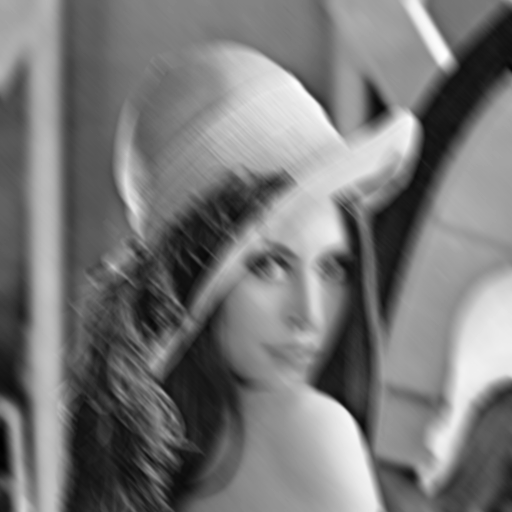

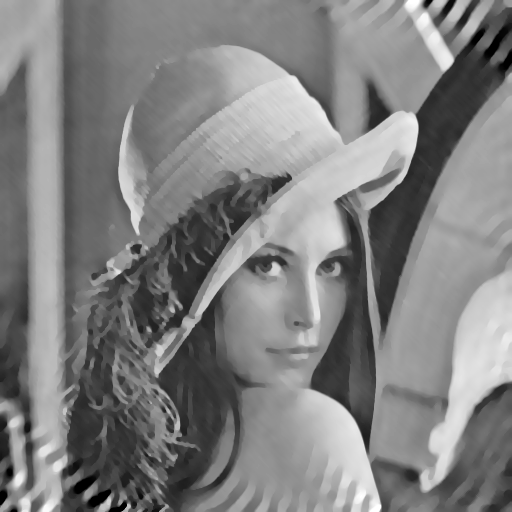

In [17]:
#%% test deconvolution
t=15
K=np.zeros((t,t))
Mh=4*t+1 #taille du spectre
for k in range(t):
    K[k,k]=1
    if k>0:
        K[k,k-1]=1
    if k<t-1:
        K[k,k+1]=1
K/=K.sum()
im=read_image(rep_images+'lena.png')/255
print(im.shape, im.max())
imconv=scipy.signal.convolve2d(im, K,mode='same',boundary='symm')
# deconv=TVdeconv(imconv,K,2000/255)
deconv,it=tv_deconv(imconv,K,lam=1000,gamma=5,max_iters=140)

def snr(x, xhat):
    num = np.sum(x**2)
    den = np.sum((x - xhat)**2) + 1e-12
    return 10.0 * np.log10(num / den)

print("SNR of the deblurred image: {:.2f} dB".format(snr(im, deconv)))
viewimage(imconv)
viewimage(deconv)

In [22]:
#%% SinglePhase Retrieval
    # Cet algorithme essaye de trouver un noyau seulement en se
# basant sur la densité de puissance de celui-ci
# Partie SINGLEPHASE_RETRIEVAL
def get_phase_alea(Mh,s=None):
    if s is None:
        s=Mh
    im=np.random.randn(Mh,Mh)
    #im[s:,:]=0
    #im[:,s:]=0
    return np.angle(np.fft.fft2(im))

def from_module_phase(module, phase):
    return np.real(np.fft.ifft2(module * np.exp(1j * phase)))

def SinglePhaseRetrieval(module,s,Mh=32,alpha=0.95,beta0=0.75,Ninner=300,known=None):
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    phg=get_phase_alea(Mh,s)
    modg=module

    if known is None:
        known=np.ones((Mh,Mh))>0
    unknown=(np.vectorize(lambda x: not x))(known)
    modg[unknown]=0
    g=from_module_phase(modg,phg)

    for m in range(Ninner):

        beta=beta0+(1-beta0)*(1-np.exp(-(m/7)**3))
        module_for_reconst=modg.copy()
        module_for_reconst[known]=(alpha*module+(1-alpha)*modg)[known]
        gp=from_module_phase(module_for_reconst,phg)
        mask=(2*gp<g)
        mask[s:,:]=True
        mask[:,s:]=True
        g[mask]=beta*g[mask]+(1-2*beta)*gp[mask]
        invmask=(np.vectorize(lambda x: not x))(mask)
        g[invmask]=gp[invmask]
        fg=fft2(g)
        phg=np.angle(fg)
        modg=abs(fg)
    g[g<0]=0
    g[s:,:]=0
    g[:,s:]=0
    g=g/g.sum()
    g[g<(1/255)]=0
    g/=g.sum()
    return g[:s,:s]




# Cellule pour tester le singlphase retrieval

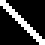

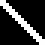

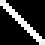

In [23]:
t=15
K=np.zeros((t,t))
Mh=4*t+1 #taille du spectre
for k in range(t):
    K[k,k]=1
    if k>0:
        K[k,k-1]=1
    if k<t-1:
        K[k,k+1]=1
K/=K.sum()

HK=abs(fft2(K,(Mh,Mh))) #on calcule un spectre de taille Mh,Mh
Ktilde=SinglePhaseRetrieval(HK,t,Mh=Mh)
viewimage(K,z=3, titre='vrai_noyau')
viewimage(Ktilde,z=3,titre='noyau_estime')
#avec erreur de spectre
HKm=HK.mean()
HKbruit=(HK+(np.random.rand(Mh,Mh)-0.5)*HKm/2).clip(min=0)
Ktildebr=SinglePhaseRetrieval(HKbruit,t,Mh=Mh)

viewimage(Ktildebr,z=3,titre='noyau_estime_avec_bruit')


In [31]:
#%% FONCTIONS CENTRALES DE L'ESTIMATION DU NOYAU DE FLOU
    # Créées suivant <https://www.ipol.im/pub/art/2018/211/>
def Dx_Dy(im):
    """ Renvoie deux images de la même taille que im. im est une image en
    niveaux de gris.
    Ce sont les dérivées suivant x et suivant y en utilisant le noyau
    dérivateur spécial """
    d=np.asarray([3,-32,168,-672,0,672,-168,32,-3])/840
    d=d.reshape((1,-1))
    Dx=scipy.signal.convolve2d(im, d,mode='same',boundary='symm')
    Dy=scipy.signal.convolve2d(im, d.T,mode='same',boundary='symm')
    return (Dx,Dy)


def entre_Mpi2_pi2(x):
    pi=np.pi
    y=x%pi
    if y>=pi/2:
        y-=pi
    return y

def liste_thetas_depuis_spectre(N):
    """ Renvoies la liste des thetas telles que pour tout point du
    spectre discret de taille NxN corresponde un angle"""
    if N%2==0:
        tmp=np.concatenate((np.arange(0,N//2+1),np.arange(-N//2+1,0)))
    else:
        tmp=np.concatenate((np.arange(0,(N+1)//2),np.arange(-(N-1)//2,0)))
    tmp=tmp.astype(np.int)
    X,Y=np.meshgrid(tmp,tmp) # carte des fréquences
    pi=np.pi
    Xs=X.reshape(-1)
    Ys=Y.reshape(-1)
    lt=[]
    c=0
    for k in range(len(Xs)):
        if Xs[k]>=0 and np.gcd(Xs[k],Ys[k])==1:
            c+=1
            an=math.atan2(Ys[k],Xs[k])
            lt.append(entre_Mpi2_pi2(an))
    lt=np.asarray(list(set(lt))) #unique
    lt=np.sort(lt)
    surech=0*lt
    for k in range(len(lt)):
        an=lt[k]
        if abs(an)<pi/4:
            surech[k]=1/cos(abs(an))
        else:
            surech[k]=1/sin(abs(an))
    return lt,surech

def projections_rapide_shear(tab,thetas,demitaille):
    """ projette tab sur toutes les droites d'angles dans thetas.
    La sortie est centree autour de la projection du point central de l'image.
    Nous faisons la projection shear: c'est à dire pas la projection orthogonale
    Cela respecte la méthode originale dans l'article
    Les angles sont censés être entre -pi/2 et pi/2
    Mais leur ordre importe peu.
    """

    L=len(thetas)
    cs=cos(thetas)
    ss=sin(thetas)
    ccs=cs.copy()
    css=ss.copy()
    # modification pour tenir compte du shear
    for m in range(len(thetas)):
        t=(thetas[m])
        if abs(t)<=pi/4:
            ccs[m]=1
            css[m]=tan(t)
        else:
            css[m]=1
            ccs[m]=cos(t)/sin(t)


    M,N=tab.shape
    T=M+N+4
    #le pixel central tombe toujours au même endroit
    poscentre=(T)//2
    kc=M//2
    lc=N//2
    out=np.zeros((L,T))
    outs1=out.reshape(-1)
    vals=np.zeros(L)
    Ls=(T*np.arange(0,L)).astype(np.int)
    for k in range(M):
        print(k/M*100,'%',end='\r')
        for l in range(N):
            pos=np.round(ccs*(l-lc)+css*(k-kc)).astype(np.int)+poscentre
            if max(pos)>T:
                print('offenders',k,l)
            vals[:]=tab[k,l]
            outs1[Ls+pos]+=vals
    return (out[:,poscentre-demitaille:poscentre+demitaille+1])

def projections_rapide_gradient_shear(DDx,DDy,DDxy,DDyx,thetas,demitaille):
    """ utile les intercorralations de Dx,Dy avec eux même pour calculer
    les projections des autocorrelations du noyau
    """

    L=len(thetas)
    cs=cos(thetas)
    ss=sin(thetas)
    cs2=cs**2
    ss2=ss**2
    csss=cs*ss
    ccs=cs.copy()
    css=ss.copy()
    # modification pour tenir compte du shear
    for m in range(len(thetas)):
        t=thetas[m]
        if abs(t)<=pi/4:
            ccs[m]=1
            css[m]=tan(t)
        else:
            css[m]=1
            ccs[m]=cos(t)/sin(t)


    M,N=DDx.shape
    T=M+N+4
    #le pixel central tombe toujours au même endroit
    poscentre=(T)//2
    kc=M//2
    lc=N//2

    out=np.zeros((L,T))
    outs1=out.reshape(-1)
    vals=np.zeros(L)
    Ls=(T*np.arange(0,L)).astype(np.int)
    for k in range(M):
        print(k/M*100,'%',end='\r')
        for l in range(N):
            pos=np.round(ccs*(l-lc)+css*(k-kc)).astype(np.int)+poscentre
            if max(pos)>T-1:
                print('offenders',k,l)
            #print("debug", k,l,DDx.shape)
            vals[:]=cs2*DDx[k,l]+ss2*DDy[k,l]+csss*(DDxy[k,l]+DDyx[k,l])
            #if vals[0]!=DDy[k,l]:
            #    print('Houston we have a problem',k,l,vals[0],DDy[k,l],cs2[0],ss2[0],csss[0])
            outs1[Ls+pos]+=vals
    return (out[:,poscentre-demitaille:poscentre+demitaille+1])

def next_power_2(T):# renvoie la puissance de deux immédiatement supérieure
    return int(2**(np.floor(np.log(T)/np.log(2))+1))

def decoupe(X,A): #decoupe une partie de tableau et la fftshift
    out1=np.concatenate((X[:A+1,-A:],X[:A+1,:A+1]),axis=1)
    out2=np.concatenate((X[-A:,-A:],X[-A:,:A+1]),axis=1)
    out=np.concatenate((out2,out1),axis=0)
    return out
def calcul_correlations_initiales(img,thetas,p):
    """ estime l'autocorrelation du noyau à partir du gradient de l'image
    La deconvolution et le filtrage median sont fait ailleurs"""



    (Dx,Dy)=Dx_Dy(img)
    # calcul des trois correlations
    (a,b)=Dx.shape
    A=next_power_2(2*a)
    B=next_power_2(2*b)
    fDx=fft2(Dx,(A,B))
    fDy=fft2(Dy,(A,B))
    DDx=real(ifft2(abs(fDx)**2))
    DDy=real(ifft2(abs(fDy)**2))
    DDxy= real(ifft2(fDx*conj(fDy)))
    DDyx= real(ifft2(fDy*conj(fDx)))
    DDx=decoupe(DDx,2*p)
    DDy=decoupe(DDy,2*p)
    DDxy=decoupe(DDxy,2*p)
    DDyx=decoupe(DDyx,2*p)


    out=projections_rapide_gradient_shear(DDx,DDy,DDxy,DDyx,thetas,2*p)
    return out


def deconv_intrinsic_blur(corr,alpha=2.1):
    """ Deconvole l'autocorrelation de la projection par un flou
    minimal dû à l'optique. """
    _,qp1=corr.shape
    M=np.zeros((qp1,qp1))
    for k in range(qp1):
        for l in range(qp1):
            M[k,l]=1/((abs(k-l)+1)**alpha)
    M/=M[0,:].sum()
    M=np.linalg.inv(M)
    deconvbrute=(M@corr.T).T
    print('shape de deconvbrut', deconvbrute.shape)
    poscentre=qp1//2
    for k in range(deconvbrute.shape[0]):
        if (deconvbrute[k,poscentre-2:poscentre+2].min())<0:
            print('failure of deconv', k,poscentre,deconvbrute[k,poscentre-2:poscentre+2] )
            deconvbrute[k]=corr[k]
    return deconvbrute


def initial_support_estimation(tab_corrs,centre,thetas,kappa=30):
    tab_interet=tab_corrs[:,centre:]
    sprime=tab_interet.argmin(axis=1)
    s=(tab_interet.shape[1]-1)*np.ones(tab_interet.shape[0])
    for k in range(tab_interet.shape[0]):
        if sprime[k]<s[k]:
            s[k]=sprime[k]
            for m in range(tab_interet.shape[0]):
                s[m]=min(s[m],\
                                   sprime[k]+\
                                       kappa*abs(thetas[m]-thetas[k]))
    return s

def Estimate_h_correlations(tab_corrs,supports):
    """ si le support est connu, on met à zéro tout ce qui dépasse.
       on enleve R[s] à tout le monde
       on normalise à somme 1"""
    centre=tab_corrs.shape[1]//2
    new_corrs=tab_corrs.copy()
    for k in range(new_corrs.shape[0]):
        sint=int(np.round(supports[k]))
        new_corrs[k,:]-=new_corrs[k,centre+sint]
        new_corrs[k,:centre-sint+1]=0
        new_corrs[k,centre+sint:]=0
        new_corrs[new_corrs<0]=0
        new_corrs[k,:]/=(new_corrs[k,:]).sum()
    # filtrage median circulaire
    taille=int(np.ceil(new_corrs.shape[0]**0.5))
    out=np.zeros(new_corrs.shape)
    #taille=0 # supprier le filtrage
    for k in range(new_corrs.shape[0]):
        if k-taille<0:
            tabmed=np.concatenate((new_corrs[:k+taille,:],new_corrs[k-taille:,:]),axis=0)
        elif k+taille+1>new_corrs.shape[0]:
            tabmed=np.concatenate((new_corrs[k-taille:,:],\
                                   new_corrs[:((k+taille+1)%new_corrs.shape[0]),:]),axis=0)
        else:
            tabmed=new_corrs[k-taille:k+taille+1,:]
        out[k,:]=np.median(tabmed,axis=0)
    return out


def Restimation_supports_noyau(h,p,thetas,ratio=0.05):
    """recalcule les autocorrelations
    du noyau a partir d'une nouvelle estiation et recalcule les supports"""

    (a,b)=h.shape
    A=next_power_2(2*a+1)
    B=next_power_2(2*b+1)
    fh=fft2(h,(A,B))
    autocor=real(ifft2(abs(fh)**2))
    autocor=decoupe(autocor,p)
    #affiche(autocor)

    proj=projections_rapide_shear(autocor,thetas,p)
    #affiche(proj)
    centre=p
    idxs=np.arange(p+1)
    out=np.zeros(thetas.shape[0])
    for k in range(proj.shape[0]):
        ma=proj[k].max()
        mask=proj[k,centre:]>(ratio*ma)
        out[k]=(idxs*mask).max()
    return out


def calcul_indices_passage_corr_power_spectrum_kernel(N,sc,thetas):
    """Calcule des indices tels que
     f=fft_corr[indices]
     donnera dans f le power spectrum de taille NxN en shape (-1)
     du noyau. fft_corr est la trasnformée de Fourier des correlations
     (en shape(-1)).
     sc est un couple
     thetas sont les angles choisis pour la correlation
     Ce calcul d'indices est fait une fois pour toute pour tous les calculs.
     N : fft2 du noyau doit etre de forme carree NxN
    """


    _,w=sc

    if N%2==0:
        tmp=np.concatenate((np.arange(0,N//2+1),np.arange(-N//2+1,0)))
    else:
        tmp=np.concatenate((np.arange(0,(N+1)//2),np.arange(-(N-1)//2,0)))
    [XX,YY]=np.meshgrid(tmp/N,tmp/N) # les frequences
    #angle=np.empty(XX.shape,dtype=np.float32)
    numligne=np.empty(XX.shape,dtype=np.int)
    posdansligne=np.empty(XX.shape,dtype=np.int)
    indexs=np.zeros(N*N,dtype=np.int)
    for k in range(XX.shape[0]):
        for l in range(XX.shape[1]):
            angle=entre_Mpi2_pi2( atan2(YY[k,l],XX[k,l]))
            #if angle<-pi/2:
            #    angle+=pi
            #elif angle>pi/2:
            #    angle-=pi
            numligne[k,l]=abs(thetas-angle).argmin()
            #if abs(thetas-angle).min()>0.001:
            #    print ('probleme')
            d=(XX[k,l]**2+YY[k,l]**2)**0.5
            if abs(thetas[numligne[k,l]])<pi/4:
                maxd=1/cos(abs(thetas[numligne[k,l]]))
            else:
                maxd=1/sin(abs(thetas[numligne[k,l]]))
            posdansligne[k,l]=min(int(np.round(d/maxd*w)),w//2)

            indexs[k*N+l]=numligne[k,l]*w+posdansligne[k,l]
    return indexs,numligne,posdansligne

def spectre_puissance_depuis_corrs(tab_corrs, N, indexs):
    """ Transforme des corrélations en spectre de puissance (NxN)
        en utilisant des indices précalculés : indexs doit pointer
        dans un tableau aplati de taille h*w.
    """
    h, w = tab_corrs.shape
    center = (w - 1) // 2

    # zero-padding / recentrage sur largeur w (PAS N)
    tmp = np.zeros((h, w))
    tmp[:, :center+1] = tab_corrs[:, center:]     # [centre..fin] → début
    tmp[:, -center:]  = tab_corrs[:, :center]     # [0..centre-1] → fin

    # FFT 1D sur l’axe des colonnes (longueur = w)
    fcorr = np.fft.fft(tmp, axis=1)               # shape = (h, w)

    out = np.zeros((N, N))

    # Aplats & sécurités
    fcorrs1 = fcorr.reshape(-1, order='C')        # taille = h*w
    outs1   = out.reshape(-1,   order='C')        # taille = N*N

    # Garde-fous utiles
    assert indexs.dtype.kind in 'iu', "indexs doit être entier"
    assert indexs.size == outs1.size, f"indexs.size={indexs.size} != N*N={N*N}"
    assert indexs.max() < fcorrs1.size, f"indexs.max()={indexs.max()} >= h*w={h*w}"

    outs1[:] = np.real(fcorrs1[indexs])
    outs1[outs1 < 0] = 0
    return out

def convol_carre(im,taille):
    """covole tres rapidement contre un carre"""
    im=im.cumsum(axis=0)
    im=im[taille:,:]-im[:-taille,:]
    im=im.cumsum(axis=1)
    im=im[:,taille:]-im[:,:-taille]
    return im

def calcul_variances_patchs(img,taille):
    """Renvoie une image des variances des patchs de taille=taille X taille
    La sortie de cette fonction permet de trouver dez petites zones dans
    l'image sur lesquels tester la deconvolution"""
    imgmoy=convol_carre(img,taille)/(taille**2)
    imgvar=convol_carre(img**2,taille)
    imgvar=imgvar-(imgmoy**2)*(taille**2)
    return imgvar

def Propose_patch_haute_variance(Varianceimage,img,taille):
    h,w=Varianceimage.shape
    xs=np.random.randint(0,high=w,size=10)
    ys=np.random.randint(0,high=h,size=10)
    pos=Varianceimage.reshape(-1)[xs+ys*w].argmax()
    print(xs[pos],ys[pos])
    return img[ys[pos]:ys[pos]+taille,xs[pos]:xs[pos]+taille].copy()

def score_restau(im): # utilisée pour comparer des resultats de deconvolution
    # entre eux.
    dx=im[:-1,1:]-im[:-1,:-1]
    dy=im[1:,:-1]-im[:-1,:-1]
    n=((dx**2)+(dy**2))**0.5
    return n.sum()/(((n**2).sum())**0.5)

In [34]:
#%% La fonction principale qui utilise toutes les composantes précédentes
def estime_noyau(img,p=25,lamb=1500/255,Nouter=3,Ntries=30,Ninner=300,\
                 verbose=True):
    t0=time.time()
    taille_patch=150
    imgvars=calcul_variances_patchs(img,taille_patch)
    Nspectrenoyau=4*p+1
    thetas,_=liste_thetas_depuis_spectre(Nspectrenoyau)
    Nthetas=thetas.shape[0]
    indexs,_,_=calcul_indices_passage_corr_power_spectrum_kernel(Nspectrenoyau,(Nthetas,4*p+1),thetas)
    #calcul des autocorrelations de projections du gradient suivant theta
    # sur l'axe theta
    cinit=calcul_correlations_initiales(img,thetas,p)
    # Deconvoluer légèrement les autocorrélations pour suppprimer un
    # "flou intrinsèque
    cdeconv=deconv_intrinsic_blur(cinit)
    # Calcul des supports initiaux
    supports=initial_support_estimation(cdeconv,2*p,thetas,kappa=30)
    # En déduire les autocorrélations puis le spectre de puissance de h
    hpower=Estimate_h_correlations(cdeconv,supports)
    H2=spectre_puissance_depuis_corrs(hpower,Nspectrenoyau,indexs)
    if verbose:
        viewimage(fftshift(H2),titre='densite_spectrale_de_puissance')
        g=SinglePhaseRetrieval(H2, p,Mh=Nspectrenoyau,Ninner=Ninner)
        viewimage(g,titre='premier_noyau_estime')
        print('temps totale de la première phase', time.time()-t0)
    # boucle pour affiner le noyau
    # Seul le support induit par le noyau amélioré est utilisé.
    # On suppose que trois itération de cette boucle suffisent pour atteindre
    # l'optimum de ce que peut faire la méthode
    # on va quand meme stocker tous les trois noyaux dans une liste
    gbests=[]
    for m in range(Nouter):
        t0=time.time()
        new_corrs=Estimate_h_correlations(cdeconv,supports)
        H2=spectre_puissance_depuis_corrs(new_corrs,Nspectrenoyau,indexs)
        cbest=None
        P=Propose_patch_haute_variance(imgvars,img,taille_patch)
        for k in range(Ntries):
            if verbose:
                print('boucle numéro',m, 'essai',k, 'sur ', Ntries)
            g=SinglePhaseRetrieval(abs(H2)**0.5,p,Mh=Nspectrenoyau)
            if (p//2)*2==p:

                gdeconv=np.zeros((p+1,p+1))
                gdeconv[:p,:p]=g
            else:
                gdeconv=g

            tmpim=tv_deconv(P,gdeconv, lam=1000,gamma=5,max_iters=40)[0]
            c=score_restau(tmpim)

            if verbose:
                print('score',c)
            if cbest is None or c<cbest:
                gbest=g.copy()
                cbest=c
            g=np.fliplr(np.flipud(g))
            if (p//2)*2==p:
                gdeconv=np.zeros((p+1,p+1))
                gdeconv[:p,:p]=g
            else:
                gdeconv=g

            tmpim=tv_deconv(P,gdeconv,lam=1000,gamma=5,max_iters=40)[0]
            c=score_restau(tmpim)
            if verbose:
                print('score flip',c)
            if c<cbest:
                gbest=g.copy()
                cbest=c
        supports=Restimation_supports_noyau(gbest,p,thetas,ratio=0.05)
        if verbose:
            viewimage(gbest,titre='tentative'+str(m))
            print('temps total de la boucle numéro',m ,'est ',time.time()-t0)
        gbests.append(gbest)
    return gbest,gbests
def centrer_le_noyau(K):
    # opération optionnelle
    p=K.shape[0]
    assert p%2==1, 'Le noyau doit être de taille impaire'
    X,Y= np.meshgrid(np.arange(p),np.arange(p))
    xm=int(np.round((X*K).sum()))
    ym=int(np.round((Y*K).sum()))
    Knew=np.zeros(K.shape)
    dx=min(p-1-xm,xm)
    dy=min(p-1-ym,ym)
    #print (xm,ym,dx,dy)
    Knew[p//2-dy:p//2+dy+1,p//2-dx:p//2+dx+1]=K[ym-dy:ym+dy+1,xm-dx:xm+dx+1]
    print('pourcentage de masse perdue', (1-Knew.sum()/K.sum())*100,'%')
    Knew/=Knew.sum()
    return Knew




# Cellules pour tester la méthode en entier

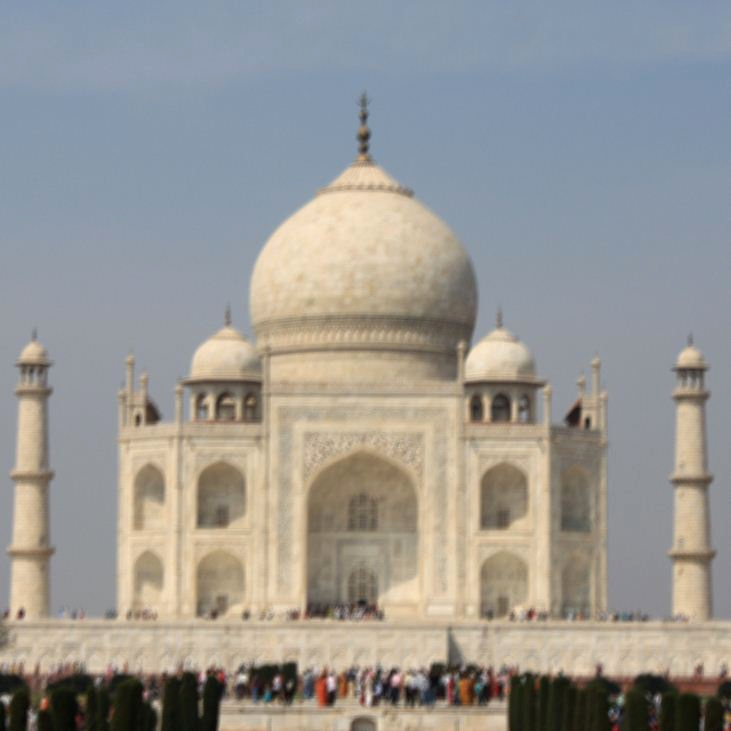

(731, 731) 0.8932902
shape de deconvbrut (3096, 101)
failure of deconv 1935 50 [1700.44800293 -247.63775342 2356.18743193 -247.63775342]


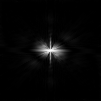

temps totale de la première phase 3.7585031986236572
366 532
boucle numéro 0 essai 0 sur  30
0.20081538863468607
score 80.19911041594659
0.20081538863468607
score flip 78.13486117636481
boucle numéro 0 essai 1 sur  30
0.20081538863468607
score 75.11855826239525
0.20081538863468607
score flip 79.28575248542663
boucle numéro 0 essai 2 sur  30
0.20081538863468607
score 77.29496334412373
0.20081538863468607
score flip 76.80400559828334
boucle numéro 0 essai 3 sur  30
0.20081538863468607
score 78.05876751412765
0.20081538863468607
score flip 76.51636935899097
boucle numéro 0 essai 4 sur  30
0.20081538863468607
score 74.0662861190368
0.20081538863468607
score flip 75.16408396330672
boucle numéro 0 essai 5 sur  30
0.20081538863468607
score 80.40260179136898
0.20081538863468607
score flip 77.72693286044598
boucle numéro 0 essai 6 sur  30
0.20081538863468607
score 74.60348808842394
0.20081538863468607
score flip 78.41595325583214
boucle numéro 0 essai 7 sur  30
0.20081538863468607
score 80.1503

temps total de la boucle numéro 0 est  17.783233880996704
224 455
boucle numéro 1 essai 0 sur  30
0.1854096920504697
score 83.10997446312659
0.1854096920504697
score flip 87.73383462463286
boucle numéro 1 essai 1 sur  30
0.1854096920504697
score 87.00036987451597
0.1854096920504697
score flip 83.44467735465247
boucle numéro 1 essai 2 sur  30
0.1854096920504697
score 82.75679073365862
0.1854096920504697
score flip 84.78949357255259
boucle numéro 1 essai 3 sur  30
0.1854096920504697
score 87.47925670594074
0.1854096920504697
score flip 82.42325262570118
boucle numéro 1 essai 4 sur  30
0.1854096920504697
score 83.56530747801143
0.1854096920504697
score flip 83.58400227693738
boucle numéro 1 essai 5 sur  30
0.1854096920504697
score 80.59449448287077
0.1854096920504697
score flip 84.77369676702384
boucle numéro 1 essai 6 sur  30
0.1854096920504697
score 80.73539885560592
0.1854096920504697
score flip 85.05192002573338
boucle numéro 1 essai 7 sur  30
0.1854096920504697
score 83.5793171403835

temps total de la boucle numéro 1 est  17.70761489868164
224 392
boucle numéro 2 essai 0 sur  30
0.1892983755873251
score 82.06411713376166
0.1892983755873251
score flip 83.49755521163753
boucle numéro 2 essai 1 sur  30
0.1892983755873251
score 81.85291154293719
0.1892983755873251
score flip 79.99636500989716
boucle numéro 2 essai 2 sur  30
0.1892983755873251
score 79.9170181040803
0.1892983755873251
score flip 78.93420121663704
boucle numéro 2 essai 3 sur  30
0.1892983755873251
score 79.46208852138469
0.1892983755873251
score flip 80.63655024351543
boucle numéro 2 essai 4 sur  30
0.1892983755873251
score 80.58415686663932
0.1892983755873251
score flip 76.62620281193172
boucle numéro 2 essai 5 sur  30
0.1892983755873251
score 78.70451030030699
0.1892983755873251
score flip 81.04002054728997
boucle numéro 2 essai 6 sur  30
0.1892983755873251
score 79.40985842833211
0.1892983755873251
score flip 78.60825735671143
boucle numéro 2 essai 7 sur  30
0.1892983755873251
score 78.77179953629576


temps total de la boucle numéro 2 est  17.880297899246216


In [35]:
#%% PARTIE INTERACTIVE


#%%
im=read_image(rep_images+'taj_mahal.png')
viewimage(im)
img,Cr,Cb=RGBtoYCrCb(im)
img = img/255
print(img.shape, img.max())

noyau,tousnoyaux=estime_noyau(img)
viewimage(noyau, 'noyau_estime')


pourcentage de masse perdue 0.0 %
0.8738871137051971
temps pour une déconvolution 0.4496729373931885
SNR de l'image défloutée: 24.82 dB


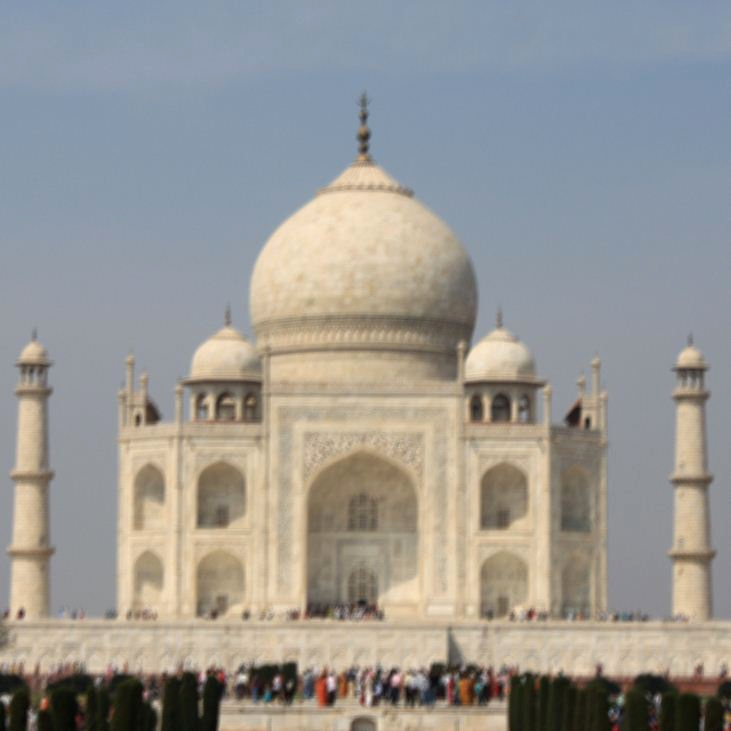

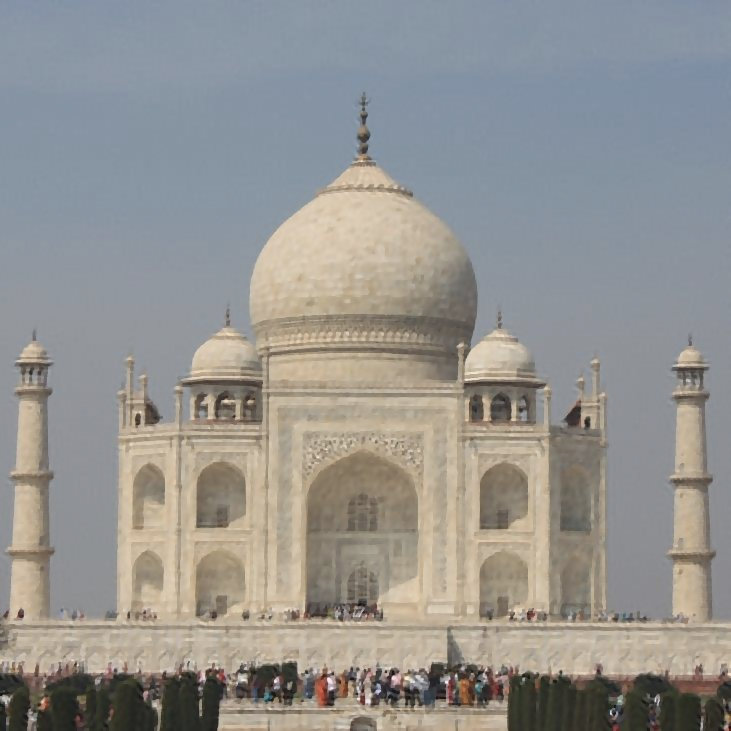

In [40]:
#%% utilisation du noyau
t0=time.time()
noyau_centre=centrer_le_noyau(noyau)
img_deconv=tv_deconv(img,noyau_centre,lam=1000,gamma=5,max_iters=140)[0]
print('temps pour une déconvolution', time.time()-t0)
img_deconv.clip(min=0,max=1,out=img_deconv) #couper les vlaeurs hors 0,255
im_deconv_couleur=YCrCbtoRGB(img_deconv*255,Cr,Cb)
snr_val=snr(im,im_deconv_couleur)
print("SNR de l'image défloutée: {:.2f} dB".format(snr_val))
viewimage(im,'ORIGINAL')
viewimage(im_deconv_couleur,'RESULT')